# Integration of CITE-seq and RNA-seq using SCREAM

We use the 10X 10k PBMC CITE-seq dataset (https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.0/pbmc_10k_protein_v3
), which includes 7,865 cells from a healthy donor stained with 14 TotalSeq-B antibodies and matched scRNA-seq data. Cell types were assigned based on established protein and gene markers and treated as the reference truth for our analyses. Cells which did not have a label were removed prior to running SCREAM

In [1]:
import os
import sys
import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
import scanpy as sc
import muon as mu
import mudata as md
mu.set_options(pull_on_update=False)

2025-09-19 14:05:39.747057: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-19 14:05:39.790867: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-19 14:05:42.902144: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
sys.path.insert(0, '/scratch/g/tgu/svenkatesan/Other/SCREAM_wf')
import SCREAM

## Define directories

In [3]:
mainDir = '/scratch/g/tgu/svenkatesan/Other/SCREAM_wf'
inputDir = os.path.join(mainDir, 'inputfiles')
rawDir = os.path.join(inputDir, 'raw')
processedDir = os.path.join(inputDir, 'processed')
results_dir = os.path.join(mainDir, 'results')

## Define global settings

In [4]:
sc.set_figure_params(dpi=100, color_map='viridis_r')
%matplotlib inline

In [5]:
print(f'Time before running script: {datetime.datetime.now().strftime("%d %b %Y %H:%M:%S")}')

Time before running script: 19 Sep 2025 14:05:50


In [6]:
t_start = datetime.datetime.now()

## Read data

In [7]:
mdata = mu.read_h5mu(os.path.join(processedDir, '10x_pbmc_10k_protein', "10xpbmc_10k_protein_processed.h5mu"))
display(mdata)

MuData object with n_obs × n_vars = 7501 × 18071
  obs:	'trueType', 'joint_leiden'
  uns:	'leiden'
  2 modalities
    rna:	7501 x 18054
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'joint_leiden', 'trueType'
      var:	'entrezgene_symbol', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts', 'log_norm', 'zscored'
      obsp:	'connectivities', 'distances'
    prot:	7501 x 17
      obs:	'leiden', 'joint_leiden', 'trueType'
      var:	'feature_name', 'feature_types', 'genome', 'pattern', 'read', 'sequence'
      uns:	'joint_leiden_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'prot:leiden_colors', 'rna:leiden_colors', 'trueType_colors', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts', 'dsb'
      obsp:	'connectivities', 'distances'

We remove cells which were assigned as unknown during cell type annotation.

In [8]:
mdata = mdata[mdata.obs['trueType']!='unknown', :].copy()

### Preprocess RNAseq data

In [9]:
rna_adata = mdata.mod['rna']
rna_adata.X = rna_adata.layers['log_norm']
sc.pp.highly_variable_genes(rna_adata, n_top_genes=500, flavor='seurat', subset=True)
rna_adata.X = rna_adata.X.todense()
display(rna_adata)

/tmp/ipykernel_2456635/1371049136.py:4: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  rna_adata.X = rna_adata.X.todense()


AnnData object with n_obs × n_vars = 6430 × 500
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'joint_leiden', 'trueType'
    var: 'entrezgene_symbol', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'log_norm', 'zscored'
    obsp: 'connectivities', 'distances'

### Pre-process CITE-seq data

In [10]:
prot_adata = mdata.mod['prot']
prot_adata = prot_adata[:, ~prot_adata.var_names.isin(['IgG2a', 'IgG1', 'IgG2b'])].copy()

In [11]:
prot_adata.X = prot_adata.layers['counts'].copy()
mu.prot.pp.clr(prot_adata)
prot_adata.layers['clr'] = prot_adata.X.copy()
prot_adata.X = prot_adata.X.todense()

/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/site-packages/muon/_prot/preproc.py:219: UserWarning: adata.X is sparse but not in CSC format. Converting to CSC.
  warn("adata.X is sparse but not in CSC format. Converting to CSC.")
/tmp/ipykernel_2456635/3191534546.py:4: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  prot_adata.X = prot_adata.X.todense()


In [12]:
sc.tl.pca(prot_adata)
sc.pp.neighbors(prot_adata)
sc.tl.umap(prot_adata)

display(prot_adata)

AnnData object with n_obs × n_vars = 6430 × 14
    obs: 'leiden', 'joint_leiden', 'trueType'
    var: 'feature_name', 'feature_types', 'genome', 'pattern', 'read', 'sequence'
    uns: 'joint_leiden_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'prot:leiden_colors', 'rna:leiden_colors', 'trueType_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'dsb', 'clr'
    obsp: 'connectivities', 'distances'

In [19]:
del rna_adata.obsp['distances'], rna_adata.obsp['connectivities']
del prot_adata.obsp['distances'], prot_adata.obsp['connectivities']

## Training

In [20]:
model_result_dir = os.path.join(results_dir, 'scream_10xpbmcprot')
scream_model = SCREAM.models.scream.SCREAM({'rna': rna_adata, "prot": prot_adata}, save_dir=model_result_dir, logger=True)

Trained models will be saved at: /scratch/g/tgu/svenkatesan/Other/SCREAM_wf/results/scream_10xpbmcprot
MuData object with n_obs × n_vars = 6430 × 514
  2 modalities
    rna:	6430 x 500
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'joint_leiden', 'trueType', 'leiden_0.1', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'leiden_0.5', 'leiden_0.6', 'leiden_0.7', 'leiden_0.8', 'leiden_0.9', 'leiden_1.0'
      var:	'entrezgene_symbol', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap', 'trueType_colors', 'leiden_0.4_colors'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts', 'log_norm', 'zscored'
    prot:	6430 x 14
      obs:	'leiden', 'joint_leiden', 'trueType', 'leiden_0.1', 'leide

### Stage 1: Train individual modalities

In [21]:
sae_rna = scream_model.pretrain_modality(modality='rna', encoding_layer_dims=[1024, 256], batch_size=128, train_test_split=None, save_encoder=True)

Folder already exists
{'batch_size': 128}


I0000 00:00:1758308770.823310 2456635 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43604 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:22:00.0, compute capability: 8.6


Model: "AE_rna"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_rna (InputLayer)          │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_0_rna (Dense)           │ (None, 1024)           │       513,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1_rna (Dense)           │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_1_rna (Dense)           │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_0_rna (Dense)           │ (None, 500)            │       512,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,551,092 (5.92 MB)

 Trainable params: 1,551,092 (5.92 MB)

 Non-trainable params: 0 (0.00 B)

None
Pretraining layer 1...
Epoch 1/150


2025-09-19 14:06:12.089915: I external/local_xla/xla/service/service.cc:163] XLA service 0x153dc0004710 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-19 14:06:12.089933: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2025-09-19 14:06:12.107907: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-19 14:06:12.151503: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200


50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3402 

I0000 00:00:1758308773.593712 2459042 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.2847 - lr: 0.1000
Epoch 2/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2238 - lr: 0.1000
Epoch 3/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2130 - lr: 0.1000
Epoch 4/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2070 - lr: 0.1000
Epoch 5/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2029 - lr: 0.1000
Epoch 6/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2000 - lr: 0.1000
Epoch 7/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1977 - lr: 0.1000
Epoch 8/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1959 - lr: 0.1000
Epoch 9/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1943 - lr: 0.1000
Epoch 10/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1930 - lr: 0.1000
Epoch 11/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1919 - lr: 0.1000
Epoch 12/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1908 - lr: 0.1000
Epoch 13/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 

2025-09-19 14:06:36.498250: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_34', 4 bytes spill stores, 4 bytes spill loads



51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.1799 - lr: 0.1000
Epoch 2/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1790 - lr: 0.1000
Epoch 3/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1786 - lr: 0.1000
Epoch 4/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1782 - lr: 0.1000
Epoch 5/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1780 - lr: 0.1000
Epoch 6/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1777 - lr: 0.1000
Epoch 7/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1775 - lr: 0.1000
Epoch 8/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1773 - lr: 0.1000
Epoch 9/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1771 - lr: 0.1000
Epoch 10/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1769 - lr: 0.1000
Epoch 11/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1767 - lr: 0.1000
Epoch 12/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1765 - lr: 0.1000
Epoch 13/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 

In [22]:
SCREAM.models.tools.plot_architecture(sae_rna.autoencoders, to_file=os.path.join(model_result_dir, 'rna_ae.png'), rankdir='LR')

{'rankdir': 'LR'}
You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [23]:
sae_prot = scream_model.pretrain_modality(modality='prot', encoding_layer_dims=[50, 25], batch_size=128, train_test_split=None, save_encoder=True)

Folder already exists
{'batch_size': 128}


Model: "AE_prot"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_prot (InputLayer)         │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_0_prot (Dense)          │ (None, 50)             │           750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1_prot (Dense)          │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_1_prot (Dense)          │ (None, 50)             │         1,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_0_prot (Dense)          │ (None, 14)             │           714 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,039 (15.78 KB)

 Trainable params: 4,039 (15.78 KB)

 Non-trainable params: 0 (0.00 B)

None
Pretraining layer 1...
Epoch 1/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.8456 - lr: 0.1000
Epoch 2/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7187 - lr: 0.1000
Epoch 3/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6910 - lr: 0.1000
Epoch 4/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6747 - lr: 0.1000
Epoch 5/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6605 - lr: 0.1000
Epoch 6/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6526 - lr: 0.1000
Epoch 7/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6498 - lr: 0.1000
Epoch 8/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6463 - lr: 0.1000
Epoch 9/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6447 - lr: 0.1000
Epoch 10/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6424 - lr: 0.1000
Epoch 11/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6391 - lr: 0.1000
Epoch 12/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6390 - lr: 0.1000
Epoch 13/150
51/51 ━

2025-09-19 14:07:07.400743: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-19 14:07:08.913887: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_909', 72 bytes spill stores, 72 bytes spill loads

2025-09-19 14:07:09.087544: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_909', 8 bytes spill stores, 8 bytes spill loads



51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.2521 - lr: 0.1000
Epoch 2/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0986 - lr: 0.1000
Epoch 3/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0794 - lr: 0.1000
Epoch 4/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0692 - lr: 0.1000
Epoch 5/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0623 - lr: 0.1000
Epoch 6/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0593 - lr: 0.1000
Epoch 7/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0565 - lr: 0.1000
Epoch 8/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0402 - lr: 0.1000
Epoch 9/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0380 - lr: 0.1000
Epoch 10/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0369 - lr: 0.1000
Epoch 11/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0355 - lr: 0.1000
Epoch 12/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0350 - lr: 0.1000
Epoch 13/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 

2025-09-19 14:07:18.916133: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-19 14:07:18.916163: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-19 14:07:20.523696: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_250', 32 bytes spill stores, 32 bytes spill loads

2025-09-19 14:07:20.646305: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.5950 - lr: 0.1000
Epoch 2/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5899 - lr: 0.1000
Epoch 3/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5883 - lr: 0.1000
Epoch 4/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5872 - lr: 0.1000
Epoch 5/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5864 - lr: 0.1000
Epoch 6/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5856 - lr: 0.1000
Epoch 7/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5849 - lr: 0.1000
Epoch 8/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5842 - lr: 0.1000
Epoch 9/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5837 - lr: 0.1000
Epoch 10/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5833 - lr: 0.1000
Epoch 11/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5829 - lr: 0.1000
Epoch 12/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5824 - lr: 0.1000
Epoch 13/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 

In [24]:
SCREAM.models.tools.plot_architecture(sae_prot.autoencoders, to_file=os.path.join(model_result_dir, 'prot_ae.png'), rankdir='LR')

{'rankdir': 'LR'}
You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [25]:
rna_adata_aftertrain = scream_model.mdata_train.mod['rna']
prot_adata_aftertrain = scream_model.mdata_train.mod['prot']

### Stage 2: Train on joint latent space

In [34]:
default_scream_opts = {'tol': 0.0001, 'n_neighbors': 15,
                       'batch_size': 128, 'method': 'leiden',
                       'do_tsne': True, 'tsne_kwargs': {'learning_rate': 200}, 'gpu_device': None,
                       'save_encoder_weights': False, 'use_ae_weights': False,
                       'do_umap': True, 'save_clustering_model': True}

In [35]:
leiden_res = sorted(set(list(np.linspace(0.1, 1, num=10).round(decimals=2)) + list(np.linspace(0.05, 0.1, num=5).round(decimals=2))))
ae_combined = scream_model.train_joint(modalities=None, clustering_resolutions=leiden_res, encoding_layer_dims=[1024, 256], max_iter=1000, **default_scream_opts)

Folder already exists
{'tol': 0.0001, 'n_neighbors': 15, 'batch_size': 128, 'method': 'leiden', 'save_encoder_weights': False, 'use_ae_weights': False}
{'learning_rate': 200}
The number of available cores is 48.
The number of cores used for training is 10.
Start to process resolution: 0.05
Training will be done on CPU.
Runtime for resolution 0.05 (HH:MM:SS): 0:00:00.000005
Rerunning autoencoder
Logged at /scratch/g/tgu/svenkatesan/Other/SCREAM_wf/results/scream_10xpbmcprot/rna_prot_joint/pretrain
Pretraining layer 1...
Epoch 1/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1013 - lr: 0.1000
Epoch 2/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0518 - lr: 0.1000
Epoch 3/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0439 - lr: 0.1000
Epoch 4/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0397 - lr: 0.1000
Epoch 5/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0368 - lr: 0.1000
Epoch 6/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0346 - lr: 0.1000


/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/scratch/g/tgu/svenkatesan/Other/SCREAM_wf/SCREAM/models/network.py:232: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata0, resolution=self.resolution)


The value of delta_label of current 1th iteration is: 0.009020217694342136 >= tol 0.0001
Epoch 1/5


2025-09-19 14:08:41.567433: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_37', 8 bytes spill stores, 8 bytes spill loads



51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.1030
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0690 
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0508 
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0392 
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0317 
The value of delta_label of current 2th iteration is: 0.0013996890047565103 >= tol 0.0001
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1615 
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1215 
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0960 
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0792 
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0676 
The value of delta_label of current 3th iteration is: 0.0006220839568413794 >= tol 0.0001
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1546 
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1331 
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step -

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 281)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_0 (Dense)               │ (None, 1024)           │       288,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ clustering (ClusteringLayer)    │ (None, 6)              │         1,536 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,105,410 (4.22 MB)

 Trainable params: 552,704 (2.11 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 552,706 (2.11 MB)

UMAP finished and added X_umap0.05 into adata.obsm



/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: In previous versions of scanpy, calling tsne with n_jobs > 1 would use MulticoreTSNE. Now this uses the scikit-learn version of TSNE by default. If you'd like the old behaviour (which is deprecated), pass 'use_fast_tsne=True'. Note, MulticoreTSNE is not actually faster anymore.
  return fn(*args_all, **kw)


TSNE finished and added X_tsne0.05 into adata.obsm

Start to process resolution: 0.06
Training will be done on CPU.
Runtime for resolution 0.06 (HH:MM:SS): 0:00:00.000011
Pretraining time (HH:MM:SS): 0:00:00.029630
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step   
...number of clusters is unknown, Initialize cluster centroid using leiden method


/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


The value of delta_label of current 1th iteration is: 0.009020217694342136 >= tol 0.0001
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1030  
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0690 
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0508 
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0392 
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0317 
The value of delta_label of current 2th iteration is: 0.0013996890047565103 >= tol 0.0001
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1615 
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1215 
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0960 
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0792 
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0676 
The value of delta_label of current 3th iteration is: 0.0006220839568413794 >= tol 0.0001
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1546 
Epoch 2/5
51/5

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 281)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_0 (Dense)               │ (None, 1024)           │       288,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ clustering (ClusteringLayer)    │ (None, 6)              │         1,536 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,105,410 (4.22 MB)

 Trainable params: 552,704 (2.11 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 552,706 (2.11 MB)

UMAP finished and added X_umap0.06 into adata.obsm



/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: In previous versions of scanpy, calling tsne with n_jobs > 1 would use MulticoreTSNE. Now this uses the scikit-learn version of TSNE by default. If you'd like the old behaviour (which is deprecated), pass 'use_fast_tsne=True'. Note, MulticoreTSNE is not actually faster anymore.
  return fn(*args_all, **kw)


TSNE finished and added X_tsne0.06 into adata.obsm

Start to process resolution: 0.08
Training will be done on CPU.
Runtime for resolution 0.08 (HH:MM:SS): 0:00:00.000011
Pretraining time (HH:MM:SS): 0:00:00.026130
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step   
...number of clusters is unknown, Initialize cluster centroid using leiden method


/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


The value of delta_label of current 1th iteration is: 0.00544323492795229 >= tol 0.0001
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1055  
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0730 
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0551 
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0435 
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0357 
The value of delta_label of current 2th iteration is: 0.0018662519287317991 >= tol 0.0001
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1666 
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1267 
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1014 
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0846 
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0729 
The value of delta_label of current 3th iteration is: 0.0013996890047565103 >= tol 0.0001
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1649 
Epoch 2/5
51/51

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 281)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_0 (Dense)               │ (None, 1024)           │       288,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ clustering (ClusteringLayer)    │ (None, 7)              │         1,792 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,105,922 (4.22 MB)

 Trainable params: 552,960 (2.11 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 552,962 (2.11 MB)

UMAP finished and added X_umap0.08 into adata.obsm



/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: In previous versions of scanpy, calling tsne with n_jobs > 1 would use MulticoreTSNE. Now this uses the scikit-learn version of TSNE by default. If you'd like the old behaviour (which is deprecated), pass 'use_fast_tsne=True'. Note, MulticoreTSNE is not actually faster anymore.
  return fn(*args_all, **kw)


TSNE finished and added X_tsne0.08 into adata.obsm

Start to process resolution: 0.09
Training will be done on CPU.
Runtime for resolution 0.09 (HH:MM:SS): 0:00:00.000010
Pretraining time (HH:MM:SS): 0:00:00.027515
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step   
...number of clusters is unknown, Initialize cluster centroid using leiden method


/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


The value of delta_label of current 1th iteration is: 0.00544323492795229 >= tol 0.0001
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1055  
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0730 
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0551 
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0435 
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0357 
The value of delta_label of current 2th iteration is: 0.0018662519287317991 >= tol 0.0001
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1666 
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1267 
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1014 
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0846 
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0729 
The value of delta_label of current 3th iteration is: 0.0013996890047565103 >= tol 0.0001
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1649 
Epoch 2/5
51/51

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 281)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_0 (Dense)               │ (None, 1024)           │       288,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ clustering (ClusteringLayer)    │ (None, 7)              │         1,792 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,105,922 (4.22 MB)

 Trainable params: 552,960 (2.11 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 552,962 (2.11 MB)

UMAP finished and added X_umap0.09 into adata.obsm



/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: In previous versions of scanpy, calling tsne with n_jobs > 1 would use MulticoreTSNE. Now this uses the scikit-learn version of TSNE by default. If you'd like the old behaviour (which is deprecated), pass 'use_fast_tsne=True'. Note, MulticoreTSNE is not actually faster anymore.
  return fn(*args_all, **kw)


TSNE finished and added X_tsne0.09 into adata.obsm

Start to process resolution: 0.1
Training will be done on CPU.
Runtime for resolution 0.1 (HH:MM:SS): 0:00:00.000011
Pretraining time (HH:MM:SS): 0:00:00.029326
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step   
...number of clusters is unknown, Initialize cluster centroid using leiden method


/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


The value of delta_label of current 1th iteration is: 0.00544323492795229 >= tol 0.0001
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1055  
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0730 
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0551 
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0435 
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0357 
The value of delta_label of current 2th iteration is: 0.0018662519287317991 >= tol 0.0001
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1666 
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1267 
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1014 
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0846 
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0729 
The value of delta_label of current 3th iteration is: 0.0013996890047565103 >= tol 0.0001
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1649 
Epoch 2/5
51/51

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 281)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_0 (Dense)               │ (None, 1024)           │       288,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ clustering (ClusteringLayer)    │ (None, 7)              │         1,792 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,105,922 (4.22 MB)

 Trainable params: 552,960 (2.11 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 552,962 (2.11 MB)

UMAP finished and added X_umap0.1 into adata.obsm



/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: In previous versions of scanpy, calling tsne with n_jobs > 1 would use MulticoreTSNE. Now this uses the scikit-learn version of TSNE by default. If you'd like the old behaviour (which is deprecated), pass 'use_fast_tsne=True'. Note, MulticoreTSNE is not actually faster anymore.
  return fn(*args_all, **kw)


TSNE finished and added X_tsne0.1 into adata.obsm

Start to process resolution: 0.2
Training will be done on CPU.
Runtime for resolution 0.2 (HH:MM:SS): 0:00:00.000010
Pretraining time (HH:MM:SS): 0:00:00.027624
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step   
...number of clusters is unknown, Initialize cluster centroid using leiden method


/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


The value of delta_label of current 1th iteration is: 0.028926905244588852 >= tol 0.0001
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.1364  
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1058 
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0865 
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0722 
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0615 
The value of delta_label of current 2th iteration is: 0.0074650077149271965 >= tol 0.0001
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2136 
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1757 
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1490 
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1295 
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1149 
The value of delta_label of current 3th iteration is: 0.006065318826586008 >= tol 0.0001
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2352 
Epoch 2/5
51/51

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 281)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_0 (Dense)               │ (None, 1024)           │       288,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ clustering (ClusteringLayer)    │ (None, 11)             │         2,816 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,107,970 (4.23 MB)

 Trainable params: 553,984 (2.11 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 553,986 (2.11 MB)

UMAP finished and added X_umap0.2 into adata.obsm



/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: In previous versions of scanpy, calling tsne with n_jobs > 1 would use MulticoreTSNE. Now this uses the scikit-learn version of TSNE by default. If you'd like the old behaviour (which is deprecated), pass 'use_fast_tsne=True'. Note, MulticoreTSNE is not actually faster anymore.
  return fn(*args_all, **kw)


TSNE finished and added X_tsne0.2 into adata.obsm

Start to process resolution: 0.3
Training will be done on CPU.
Runtime for resolution 0.3 (HH:MM:SS): 0:00:00.000011
Pretraining time (HH:MM:SS): 0:00:00.027761
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step   
...number of clusters is unknown, Initialize cluster centroid using leiden method


/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


The value of delta_label of current 1th iteration is: 0.03094867803156376 >= tol 0.0001
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1495  
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1222 
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1039 
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0899 
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0789 
The value of delta_label of current 2th iteration is: 0.008864697068929672 >= tol 0.0001
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2232 
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1892 
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1641 
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1454 
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1310 
The value of delta_label of current 3th iteration is: 0.007309486623853445 >= tol 0.0001
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2533 
Epoch 2/5
51/51 ━

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 281)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_0 (Dense)               │ (None, 1024)           │       288,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ clustering (ClusteringLayer)    │ (None, 13)             │         3,328 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,108,994 (4.23 MB)

 Trainable params: 554,496 (2.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 554,498 (2.12 MB)

UMAP finished and added X_umap0.3 into adata.obsm



/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: In previous versions of scanpy, calling tsne with n_jobs > 1 would use MulticoreTSNE. Now this uses the scikit-learn version of TSNE by default. If you'd like the old behaviour (which is deprecated), pass 'use_fast_tsne=True'. Note, MulticoreTSNE is not actually faster anymore.
  return fn(*args_all, **kw)


TSNE finished and added X_tsne0.3 into adata.obsm

Start to process resolution: 0.4
Training will be done on CPU.
Runtime for resolution 0.4 (HH:MM:SS): 0:00:00.000008
Pretraining time (HH:MM:SS): 0:00:00.025564
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step   
...number of clusters is unknown, Initialize cluster centroid using leiden method


/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


The value of delta_label of current 1th iteration is: 0.036236390471458435 >= tol 0.0001
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1643  
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1363 
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1167 
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1014 
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0894 
The value of delta_label of current 2th iteration is: 0.009642302058637142 >= tol 0.0001
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2398 
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2061 
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1808 
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1616 
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1468 
The value of delta_label of current 3th iteration is: 0.007931570522487164 >= tol 0.0001
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2686 
Epoch 2/5
51/51 

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 281)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_0 (Dense)               │ (None, 1024)           │       288,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ clustering (ClusteringLayer)    │ (None, 14)             │         3,584 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,109,506 (4.23 MB)

 Trainable params: 554,752 (2.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 554,754 (2.12 MB)

UMAP finished and added X_umap0.4 into adata.obsm



/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: In previous versions of scanpy, calling tsne with n_jobs > 1 would use MulticoreTSNE. Now this uses the scikit-learn version of TSNE by default. If you'd like the old behaviour (which is deprecated), pass 'use_fast_tsne=True'. Note, MulticoreTSNE is not actually faster anymore.
  return fn(*args_all, **kw)


TSNE finished and added X_tsne0.4 into adata.obsm

Start to process resolution: 0.5
Training will be done on CPU.
Runtime for resolution 0.5 (HH:MM:SS): 0:00:00.000012
Pretraining time (HH:MM:SS): 0:00:00.028269
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step   
...number of clusters is unknown, Initialize cluster centroid using leiden method


/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


The value of delta_label of current 1th iteration is: 0.03374805673956871 >= tol 0.0001
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1645  
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1365 
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1170 
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1017 
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0896 
The value of delta_label of current 2th iteration is: 0.010419907048344612 >= tol 0.0001
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2395 
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2058 
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1805 
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1614 
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1465 
The value of delta_label of current 3th iteration is: 0.00839813333004713 >= tol 0.0001
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2684 
Epoch 2/5
51/51 ━━

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 281)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_0 (Dense)               │ (None, 1024)           │       288,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ clustering (ClusteringLayer)    │ (None, 14)             │         3,584 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,109,506 (4.23 MB)

 Trainable params: 554,752 (2.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 554,754 (2.12 MB)

UMAP finished and added X_umap0.5 into adata.obsm



/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: In previous versions of scanpy, calling tsne with n_jobs > 1 would use MulticoreTSNE. Now this uses the scikit-learn version of TSNE by default. If you'd like the old behaviour (which is deprecated), pass 'use_fast_tsne=True'. Note, MulticoreTSNE is not actually faster anymore.
  return fn(*args_all, **kw)


TSNE finished and added X_tsne0.5 into adata.obsm

Start to process resolution: 0.6
Training will be done on CPU.
Runtime for resolution 0.6 (HH:MM:SS): 0:00:00.000012
Pretraining time (HH:MM:SS): 0:00:00.026130
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step   
...number of clusters is unknown, Initialize cluster centroid using leiden method


/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


The value of delta_label of current 1th iteration is: 0.03545878827571869 >= tol 0.0001
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.1681  
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1403 
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1209 
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1056 
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0935 
The value of delta_label of current 2th iteration is: 0.012908242642879486 >= tol 0.0001
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2471 
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2139 
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1887 
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1696 
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1546 
The value of delta_label of current 3th iteration is: 0.011819595471024513 >= tol 0.0001
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2787 
Epoch 2/5
51/51 ━

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 281)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_0 (Dense)               │ (None, 1024)           │       288,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ clustering (ClusteringLayer)    │ (None, 15)             │         3,840 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,110,018 (4.23 MB)

 Trainable params: 555,008 (2.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 555,010 (2.12 MB)

UMAP finished and added X_umap0.6 into adata.obsm



/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: In previous versions of scanpy, calling tsne with n_jobs > 1 would use MulticoreTSNE. Now this uses the scikit-learn version of TSNE by default. If you'd like the old behaviour (which is deprecated), pass 'use_fast_tsne=True'. Note, MulticoreTSNE is not actually faster anymore.
  return fn(*args_all, **kw)


TSNE finished and added X_tsne0.6 into adata.obsm

Start to process resolution: 0.7
Training will be done on CPU.
Runtime for resolution 0.7 (HH:MM:SS): 0:00:00.000011
Pretraining time (HH:MM:SS): 0:00:00.026663
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step   
...number of clusters is unknown, Initialize cluster centroid using leiden method


/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


The value of delta_label of current 1th iteration is: 0.04743390530347824 >= tol 0.0001
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1811  
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1537 
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1339 
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1181 
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1054 
The value of delta_label of current 2th iteration is: 0.018818041309714317 >= tol 0.0001
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2625 
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2313 
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2070 
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1882 
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1733 
The value of delta_label of current 3th iteration is: 0.015241057612001896 >= tol 0.0001
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3001 
Epoch 2/5
51/51 ━

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 281)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_0 (Dense)               │ (None, 1024)           │       288,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ clustering (ClusteringLayer)    │ (None, 17)             │         4,352 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,111,042 (4.24 MB)

 Trainable params: 555,520 (2.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 555,522 (2.12 MB)

UMAP finished and added X_umap0.7 into adata.obsm



/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: In previous versions of scanpy, calling tsne with n_jobs > 1 would use MulticoreTSNE. Now this uses the scikit-learn version of TSNE by default. If you'd like the old behaviour (which is deprecated), pass 'use_fast_tsne=True'. Note, MulticoreTSNE is not actually faster anymore.
  return fn(*args_all, **kw)


TSNE finished and added X_tsne0.7 into adata.obsm

Start to process resolution: 0.8
Training will be done on CPU.
Runtime for resolution 0.8 (HH:MM:SS): 0:00:00.000013
Pretraining time (HH:MM:SS): 0:00:00.030180
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step   
...number of clusters is unknown, Initialize cluster centroid using leiden method


/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


The value of delta_label of current 1th iteration is: 0.046656299382448196 >= tol 0.0001
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1805  
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1531 
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1334 
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1176 
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1050 
The value of delta_label of current 2th iteration is: 0.019284604117274284 >= tol 0.0001
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2618 
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2304 
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2061 
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1873 
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1724 
The value of delta_label of current 3th iteration is: 0.019284604117274284 >= tol 0.0001
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3001 
Epoch 2/5
51/51 

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 281)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_0 (Dense)               │ (None, 1024)           │       288,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ clustering (ClusteringLayer)    │ (None, 17)             │         4,352 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,111,042 (4.24 MB)

 Trainable params: 555,520 (2.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 555,522 (2.12 MB)

UMAP finished and added X_umap0.8 into adata.obsm



/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: In previous versions of scanpy, calling tsne with n_jobs > 1 would use MulticoreTSNE. Now this uses the scikit-learn version of TSNE by default. If you'd like the old behaviour (which is deprecated), pass 'use_fast_tsne=True'. Note, MulticoreTSNE is not actually faster anymore.
  return fn(*args_all, **kw)


TSNE finished and added X_tsne0.8 into adata.obsm

Start to process resolution: 0.9
Training will be done on CPU.
Runtime for resolution 0.9 (HH:MM:SS): 0:00:00.000011
Pretraining time (HH:MM:SS): 0:00:00.030117
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step   
...number of clusters is unknown, Initialize cluster centroid using leiden method


/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


The value of delta_label of current 1th iteration is: 0.04650077596306801 >= tol 0.0001
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1808  
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1534 
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1337 
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1179 
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1052 
The value of delta_label of current 2th iteration is: 0.022083980962634087 >= tol 0.0001
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2623 
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2309 
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2065 
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1877 
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1728 
The value of delta_label of current 3th iteration is: 0.01866251975297928 >= tol 0.0001
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3008 
Epoch 2/5
51/51 ━━

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 281)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_0 (Dense)               │ (None, 1024)           │       288,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ clustering (ClusteringLayer)    │ (None, 17)             │         4,352 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,111,042 (4.24 MB)

 Trainable params: 555,520 (2.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 555,522 (2.12 MB)

UMAP finished and added X_umap0.9 into adata.obsm



/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: In previous versions of scanpy, calling tsne with n_jobs > 1 would use MulticoreTSNE. Now this uses the scikit-learn version of TSNE by default. If you'd like the old behaviour (which is deprecated), pass 'use_fast_tsne=True'. Note, MulticoreTSNE is not actually faster anymore.
  return fn(*args_all, **kw)


TSNE finished and added X_tsne0.9 into adata.obsm

Start to process resolution: 1.0
Training will be done on CPU.
Runtime for resolution 1.0 (HH:MM:SS): 0:00:00.000007
Pretraining time (HH:MM:SS): 0:00:00.028338
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step   
...number of clusters is unknown, Initialize cluster centroid using leiden method


/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


The value of delta_label of current 1th iteration is: 0.04510108754038811 >= tol 0.0001
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1808  
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1534 
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1336 
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1178 
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1051 
The value of delta_label of current 2th iteration is: 0.017573872581124306 >= tol 0.0001
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2621 
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2309 
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2066 
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1878 
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1729 
The value of delta_label of current 3th iteration is: 0.016018662601709366 >= tol 0.0001
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2996 
Epoch 2/5
51/51 ━

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 281)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_0 (Dense)               │ (None, 1024)           │       288,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ clustering (ClusteringLayer)    │ (None, 17)             │         4,352 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,111,042 (4.24 MB)

 Trainable params: 555,520 (2.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 555,522 (2.12 MB)

UMAP finished and added X_umap1.0 into adata.obsm



/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: In previous versions of scanpy, calling tsne with n_jobs > 1 would use MulticoreTSNE. Now this uses the scikit-learn version of TSNE by default. If you'd like the old behaviour (which is deprecated), pass 'use_fast_tsne=True'. Note, MulticoreTSNE is not actually faster anymore.
  return fn(*args_all, **kw)


TSNE finished and added X_tsne1.0 into adata.obsm

Total time to run DESC (HH:MM:SS): 0:11:54.864090
MuData object with n_obs × n_vars = 6430 × 514
  obs:	'desc_0.05', 'desc_0.06', 'desc_0.08', 'desc_0.09', 'desc_0.1', 'desc_0.2', 'desc_0.3', 'desc_0.4', 'desc_0.5', 'desc_0.6', 'desc_0.7', 'desc_0.8', 'desc_0.9', 'desc_1.0'
  uns:	'prob_matrix0.05', 'umap', 'tsne', 'prob_matrix0.06', 'prob_matrix0.08', 'prob_matrix0.09', 'prob_matrix0.1', 'prob_matrix0.2', 'prob_matrix0.3', 'prob_matrix0.4', 'prob_matrix0.5', 'prob_matrix0.6', 'prob_matrix0.7', 'prob_matrix0.8', 'prob_matrix0.9', 'prob_matrix1.0'
  obsm:	'joint_ls', 'X_Embedded_z0.05', 'X_umap', 'X_umap0.05', 'X_tsne', 'X_tsne0.05', 'X_Embedded_z0.06', 'X_umap0.06', 'X_tsne0.06', 'X_Embedded_z0.08', 'X_umap0.08', 'X_tsne0.08', 'X_Embedded_z0.09', 'X_umap0.09', 'X_tsne0.09', 'X_Embedded_z0.1', 'X_umap0.1', 'X_tsne0.1', 'X_Embedded_z0.2', 'X_umap0.2', 'X_tsne0.2', 'X_Embedded_z0.3', 'X_umap0.3', 'X_tsne0.3', 'X_Embedded_z0.4', 'X_umap0.4

In [36]:
SCREAM.models.tools.plot_architecture(ae_combined.model, to_file=os.path.join(model_result_dir, 'joint_ae.png'), rankdir='LR')

{'rankdir': 'LR'}
You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


## Plot cluster evaluation metrics

In [41]:
leiden_res = sorted(set(list(np.linspace(0.1, 1, num=10).round(decimals=2)) + list(np.linspace(0.05, 0.1, num=5).round(decimals=2))))

In [42]:
ari_pd = SCREAM.models.tools.calc_ari(scream_model.mdata_train, label_col='rna:trueType', cluster_res=leiden_res)
nmi_pd = SCREAM.models.tools.calc_nmi(scream_model.mdata_train, label_col='rna:trueType', cluster_res=leiden_res)
sil_pd = SCREAM.models.tools.calc_silhouette(scream_model.mdata_train, cluster_res=leiden_res)
metrics_df = ari_pd.join([nmi_pd, sil_pd])

{}


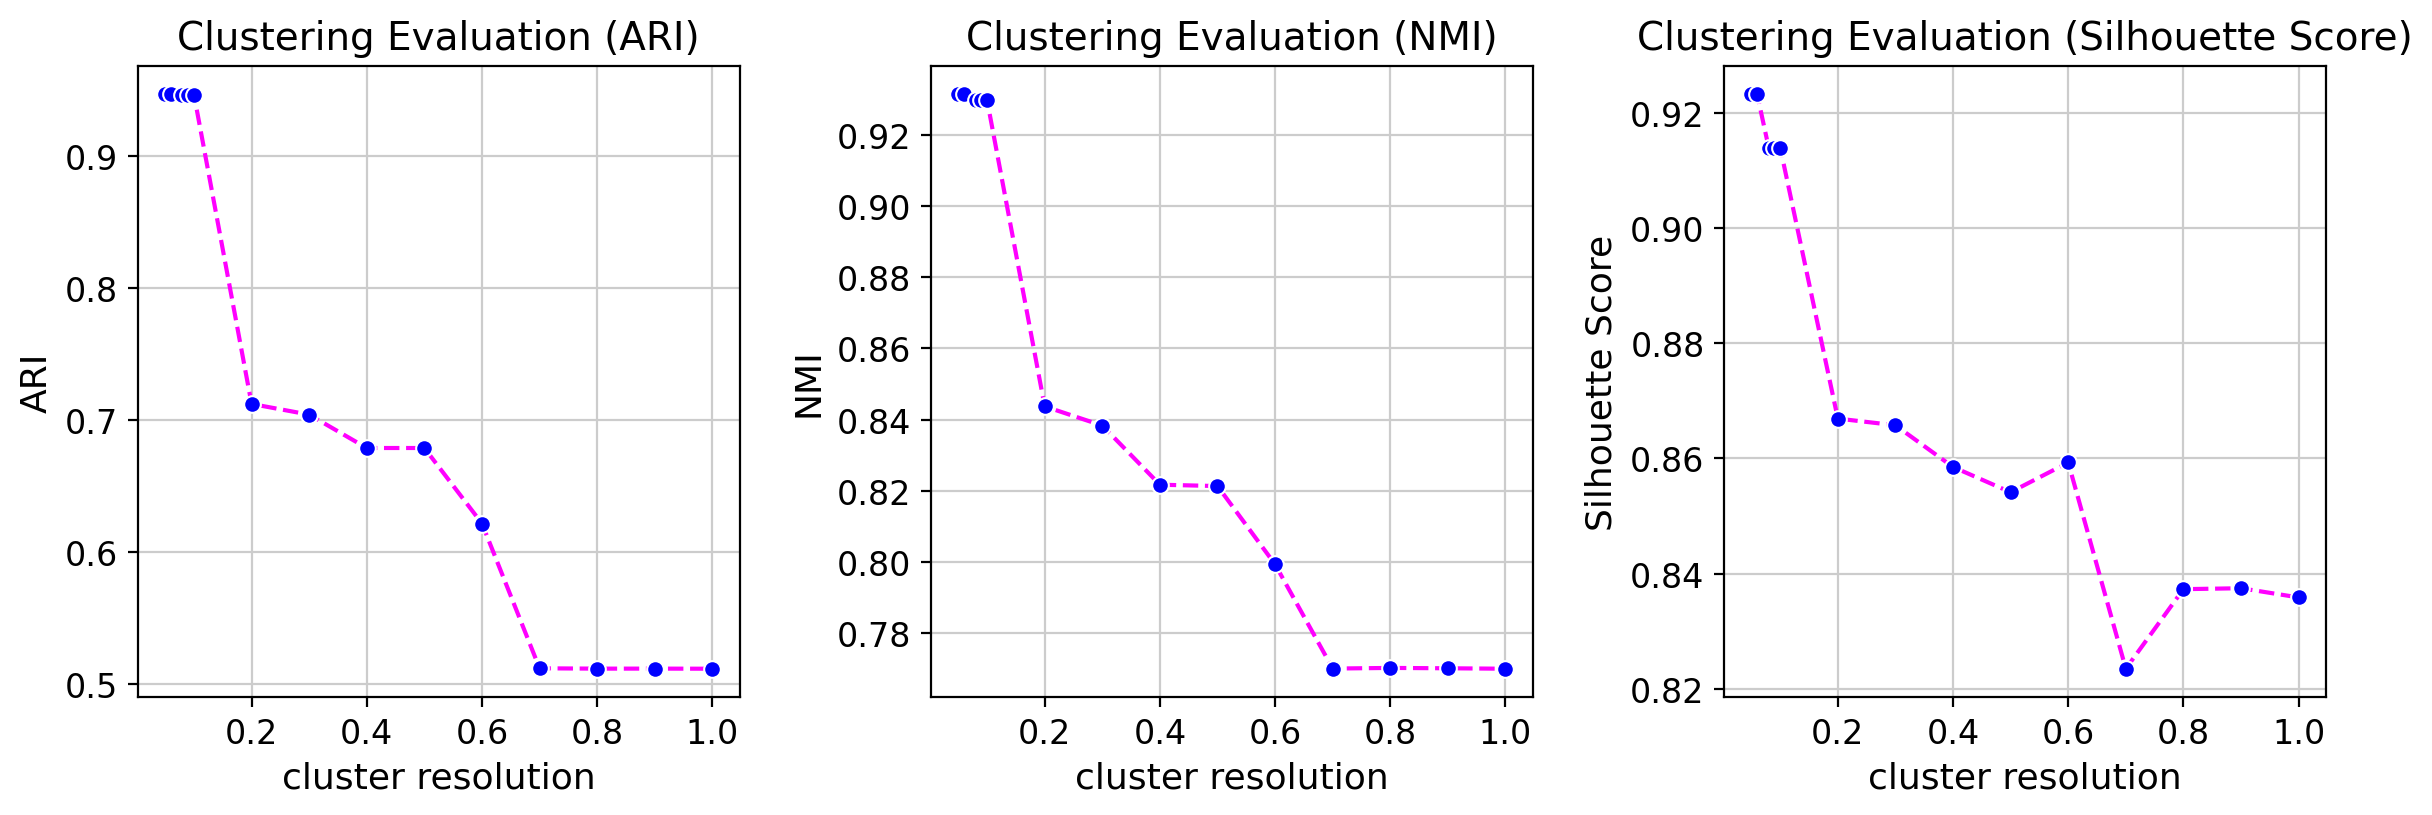

In [43]:
fig = SCREAM.models.tools.plot_clustereval(metrics_df, res_col='cluster resolution', met_cols=None, ncols=5, figsize=None)

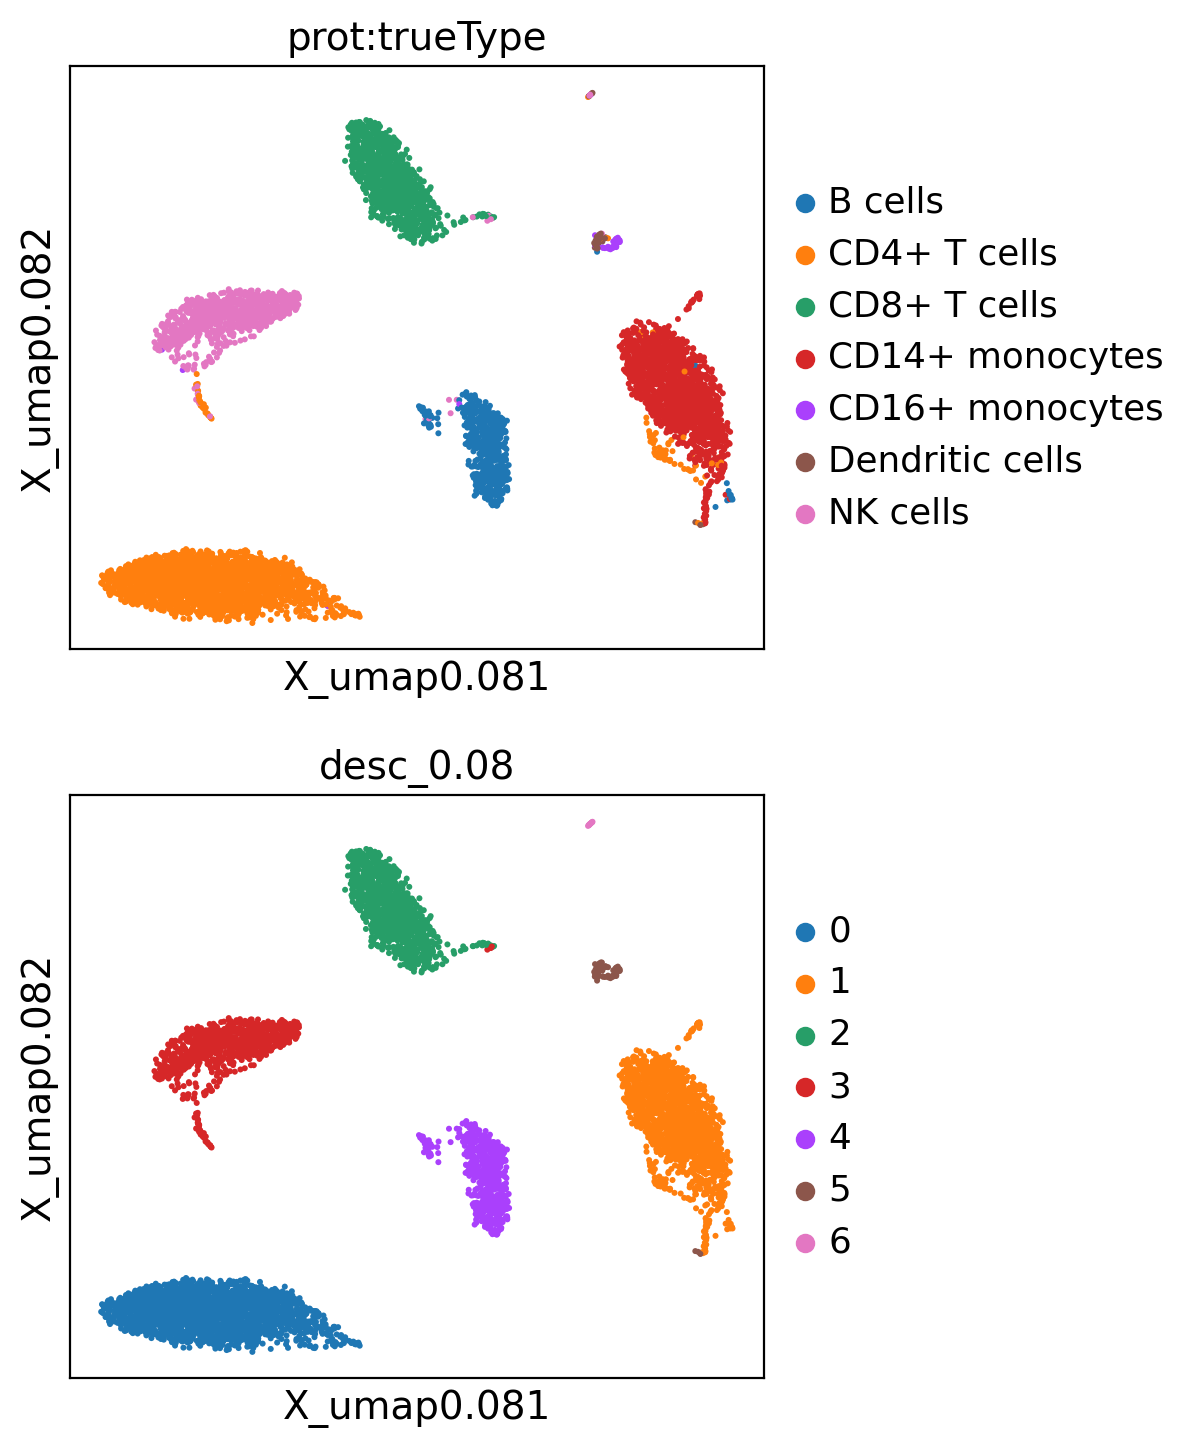

In [44]:
fig = mu.pl.embedding(scream_model.mdata_train, basis='X_umap0.08', color=['prot:trueType', 'desc_0.08'], ncols=1)

In [45]:
print(f'Time to run script (HH:MM:SS): {str(datetime.datetime.now() - t_start)}')

Time to run script (HH:MM:SS): 0:14:40.022978


In [46]:
scream_model.mdata_train.write_h5mu(os.path.join(processedDir, 'scream_10xpbmc_10k_protein.h5mu'))